In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

# Load data set
- clean sentences by removing special characters
- Add a start and end token to each sentence
- create a word index and reverse word index
- Pad each sentence to a maximum length

In [ ]:
#Download the file

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)
print(path_to_zip)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"
print(path_to_file)

2654208/2638744 [==============================] - 0s 0us/step
/root/.keras/datasets/spa-eng.zip
/root/.keras/datasets/spa-eng/spa.txt


In [ ]:
#Preprocessing
#1. convert unicode files to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  #creating a space between a word and the punctuation following it
  # w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r"([.,!?¿])", r" \1 ", w)
  w = re.sub('\s{2,}', ' ', w)

  #replacing everything with space, except letters, punctuations ...
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()

  #adding start and end tokens
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])
print(len(en), len(sp))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964 118964


In [ ]:
#tokenize the sentence and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

11 16


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(input_tensor_train[0])
print(target_tensor_train[0])

24000 24000 6000 6000
[  1  25   8   7 557   3   2   0   0   0   0   0   0   0   0   0]
[  1  27  11  34   9 466   3   2   0   0   0]


# Create a tf.data dataset

- create a source dataset from your input data
- Apply dataset transformations to preprocess the data
- Iterate over the dataset and process the elements


Iteration occurs in streaming fashion, so the full dataset does not need to fit into memory

In [ ]:
#configuration
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256 #for word embeddings
units = 1024 ##dimensionality of the output space of the RNN
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch  = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

# Making the basic seq2seq model

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    print("X:", x.shape)
    x = self.embedding(x)
    print("XE:", x.shape)
    output, state = self.gru(x, initial_state=hidden)
    print("A:", output.shape)
    print("B:", state.shape)
    output = tf.reshape(output, (-1,output.shape[2]))
    print("C:", output.shape)
    x = self.fc(output)
    print("D:", x.shape)
    return x,state

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

X: (64, 1)
XE: (64, 1, 256)
A: (64, 1, 1024)
B: (64, 1024)
C: (64, 1024)
D: (64, 4935)
Decoder output shape: (batch_size, vocab size) (64, 4935)


# Dot product attention

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(DotProductAttention,self).__init__()
    self.WK = tf.keras.layers.Dense(units)
    self.WQ= tf.keras.layers.Dense(units)

  def call(self, query, values):
    #query -> s
    #values -> h1 .. hn
    query_with_time_axis = tf.expand_dims(query,1)

    K = self.WK(values)
    Q = self.WQ(query_with_time_axis)
    QT = tf.einsum('ijk->ikj',Q)
    score = tf.matmul(K, QT)

    attention_weights = tf.nn.softmax(score,axis=1)

    context_vector = attention_weights*values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = DotProductAttention(units)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


# Additive Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2= tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self,query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))

    attention_weights = tf.nn.softmax(score,axis=1)

    context_vector = attention_weights*values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# Decoder with Attention

In [ ]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention=None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = attention

  def call(self, x, hidden, enc_output):
    x = self.embedding(x)
    attention_weights=None

    if self.attention:
      context_vector, attention_weights = self.attention(hidden, enc_output)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x, initial_state=hidden)
    output = tf.reshape(output, (-1,output.shape[2]))
    x = self.fc(output)

    return x,state,attention_weights

# Loss function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real,pred):
  loss_ = loss_object(real,pred)
  return tf.reduce_mean(loss_)

In [ ]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))
print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


# Training

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def get_train_step_function():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE, 1)

      for t in range(1,targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:,t],1)

    batch_loss = (loss/int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
  return train_step

In [ ]:
def calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE,1)

  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss+=loss_function(targ[:,t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss/int(targ.shape[1])
  return loss

In [ ]:
def training_seq2seq(epochs,attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_function()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss+=batch_loss

      if batch%100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))

    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0

    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch_val)):
      val_loss = calculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss/steps_per_epoch)
    validation_loss.append(total_val_loss/steps_per_epoch_val)

    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1, training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  return encoder, decoder, training_loss, validation_loss

# Training seq2seq without attention

In [ ]:
epochs = 20
attention = None
print("Running seq2seq model without attention")
encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = training_loss
vloss = validation_loss

Running seq2seq model without attention
Epoch 1 Batch 0 Loss 7.7318
Epoch 1 Batch 100 Loss 2.1228
Epoch 1 Batch 200 Loss 1.9890
Epoch 1 Batch 300 Loss 1.7133
Epoch 1 Loss 2.0923 Validation Loss 1.6123
Time taken for 1 epoch 65.80152082443237 sec

Epoch 2 Batch 0 Loss 1.4999
Epoch 2 Batch 100 Loss 1.5323
Epoch 2 Batch 200 Loss 1.4634
Epoch 2 Batch 300 Loss 1.3660
Epoch 2 Loss 1.4199 Validation Loss 1.3065
Time taken for 1 epoch 43.83407735824585 sec

Epoch 3 Batch 0 Loss 1.1820
Epoch 3 Batch 100 Loss 1.1052
Epoch 3 Batch 200 Loss 1.1835
Epoch 3 Batch 300 Loss 1.0444
Epoch 3 Loss 1.0788 Validation Loss 1.1353
Time taken for 1 epoch 43.41390919685364 sec

Epoch 4 Batch 0 Loss 0.8849
Epoch 4 Batch 100 Loss 0.8237
Epoch 4 Batch 200 Loss 0.8856
Epoch 4 Batch 300 Loss 0.8028
Epoch 4 Loss 0.8394 Validation Loss 1.0241
Time taken for 1 epoch 43.49695420265198 sec

Epoch 5 Batch 0 Loss 0.6109
Epoch 5 Batch 100 Loss 0.6058
Epoch 5 Batch 200 Loss 0.7444
Epoch 5 Batch 300 Loss 0.6671
Epoch 5 Loss 0

In [ ]:
attention = DotProductAttention(units)
print("Running seq2seq model with dot product attention")
encoder_dp, decoder_dp, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

Running seq2seq model with dot product attention
Epoch 1 Batch 0 Loss 7.7311
Epoch 1 Batch 100 Loss 2.5156
Epoch 1 Batch 200 Loss 1.8885
Epoch 1 Batch 300 Loss 1.8738
Epoch 1 Loss 2.4150 Validation Loss 1.8649
Time taken for 1 epoch 94.58045315742493 sec

Epoch 2 Batch 0 Loss 1.8512
Epoch 2 Batch 100 Loss 1.5898
Epoch 2 Batch 200 Loss 1.4620
Epoch 2 Batch 300 Loss 1.5177
Epoch 2 Loss 1.5848 Validation Loss 1.5170
Time taken for 1 epoch 77.13783073425293 sec

Epoch 3 Batch 0 Loss 1.3080
Epoch 3 Batch 100 Loss 1.2058
Epoch 3 Batch 200 Loss 1.3574
Epoch 3 Batch 300 Loss 1.2462
Epoch 3 Loss 1.2923 Validation Loss 1.3447
Time taken for 1 epoch 77.12297630310059 sec

Epoch 4 Batch 0 Loss 1.0964
Epoch 4 Batch 100 Loss 1.0699
Epoch 4 Batch 200 Loss 1.2635
Epoch 4 Batch 300 Loss 1.0615
Epoch 4 Loss 1.0916 Validation Loss 1.2427
Time taken for 1 epoch 77.53688836097717 sec

Epoch 5 Batch 0 Loss 0.8499
Epoch 5 Batch 100 Loss 1.0291
Epoch 5 Batch 200 Loss 0.8472
Epoch 5 Batch 300 Loss 0.9055
Epoch

In [ ]:
epochs = 20

attention = BahdanauAttention(units)
print("Running seq2seq model with Bahdanau attention")
encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

Running seq2seq model with Bahdanau attention
Epoch 1 Batch 0 Loss 7.7280
Epoch 1 Batch 100 Loss 3.1505
Epoch 1 Batch 200 Loss 2.6946
Epoch 1 Batch 300 Loss 2.6451
Epoch 1 Loss 3.1679 Validation Loss 2.4052
Time taken for 1 epoch 95.46813035011292 sec

Epoch 2 Batch 0 Loss 2.2939
Epoch 2 Batch 100 Loss 2.2124
Epoch 2 Batch 200 Loss 2.0370
Epoch 2 Batch 300 Loss 1.9225
Epoch 2 Loss 2.1305 Validation Loss 2.0288
Time taken for 1 epoch 78.92238354682922 sec

Epoch 3 Batch 0 Loss 1.9779
Epoch 3 Batch 100 Loss 1.9651
Epoch 3 Batch 200 Loss 1.8655
Epoch 3 Batch 300 Loss 1.7625
Epoch 3 Loss 1.7708 Validation Loss 1.7417
Time taken for 1 epoch 78.77114820480347 sec

Epoch 4 Batch 0 Loss 1.4712
Epoch 4 Batch 100 Loss 1.5739
Epoch 4 Batch 200 Loss 1.5956
Epoch 4 Batch 300 Loss 1.4949
Epoch 4 Loss 1.5103 Validation Loss 1.5628
Time taken for 1 epoch 78.99677038192749 sec

Epoch 5 Batch 0 Loss 1.3392
Epoch 5 Batch 100 Loss 1.3150
Epoch 5 Batch 200 Loss 1.2526
Epoch 5 Batch 300 Loss 1.1983
Epoch 5 

Text(0.5, 1.0, 'Validation loss')

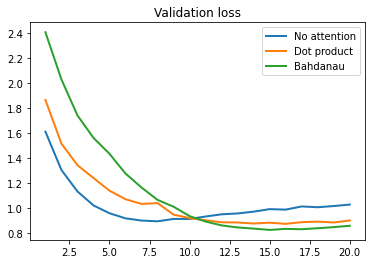

In [ ]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
t = np.arange(1, epochs+1)

for i in range(0, vloss.shape[0]):
  line, = plt.plot(t, vloss[i,:], lw=2)

ax.legend(('No attention', 'Dot product', 'Bahdanau'))
ax.set_title("Validation loss")

#Translate

In [ ]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp, padding='post')

  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1,units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    dec_input = tf.expand_dims([predicted_id], 0)
  return result, sentence

In [ ]:
result, sentence = translate(u'esta es mi vida.', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


In [ ]:
result, sentence = translate(u'esta es mi vida.', encoder_dp, decoder_dp)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


In [ ]:
result, sentence = translate(u'¿todavia estan en casa?', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


In [ ]:
result, sentence = translate(u'tengo un gato negro.', encoder_dp, decoder_dp)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> tengo un gato negro . <end>
Predicted translation: i have a black cat . <end> 
